# Base

In [1]:
import json
import os
import numpy as np
import datetime
import cv2
import random
import re
import multiprocessing

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # "0, 1" for multiple

In [2]:
from tensorflow.python.ops import math_ops
from tensorflow.python.keras._impl.keras import backend as K

/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import tensorflow as tf

In [4]:
# adam, momentum or nesterov
opt_string = "momentum"

LEARNING_RATE = 0.001
#using in lr decay
LR_DECAY = 0.95
#using in momentum and nesterov
MOMENTUM = 0.9
#using in adam
ADAM_BETA_1 = 0.9
ADAM_BETA_2 = 0.99

#base hyper-parameter
INPUT_SHAPE = (1024,512,3)
MEAN_PIXEL = np.array([93.2,104.6,116.6])
BATCH_SIZE = 40
VALIDATION_STEPS = 30
CLASS_NUMS = 4
IS_SAVE = False

In [5]:
im_dir = './dataset/image_women/'
train_json = './dataset/women_train_label.json'
val_json = './dataset/women_val_label.json'
sample_json = './dataset/women_sample_label.json'
base_dir = './logs'

In [6]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
tf.keras.backend.set_session(session)

In [7]:
def build_model():
    resnet_model = tf.keras.applications.resnet50.ResNet50(include_top=False,
                                weights='imagenet',input_shape=INPUT_SHAPE,pooling='avg')
    resnet_output = resnet_model.output

    resnet_input = resnet_model.input

    #fla_fm = tf.keras.layers.Flatten()(resnet_output)

    output = tf.keras.layers.Dense(CLASS_NUMS,activation='softmax',name='fc_softmax')(resnet_output)

    sm_model = tf.keras.models.Model(inputs = resnet_input,outputs = output, name = 'res50_softmax')

    return sm_model

In [8]:
def set_trainable(pattern, keras_model=None, verbose=1):
    """Sets model layers as trainable if their names match
    the given regular expression.
    """
    print("\nIn:",keras_model.name)
    print("The trainable layers:")
    # In multi-GPU training, we wrap the model. Get layers
    # of the inner model because they have the weights.
    layers = keras_model.layers
    for layer in layers:
        # Is the layer a model?
        if layer.__class__.__name__ == 'Model':
            set_trainable(
                pattern, keras_model=layer)
            continue

        if not layer.weights:
            continue
        # Is it trainable?
        trainable = bool(re.fullmatch(pattern, layer.name))
        # Update layer. If layer is a container, update inner layer.
        layer.trainable = trainable
        # Print trainble layer names
        if trainable and verbose > 0:
            print(" ",layer.name)

In [9]:
def imread(path):
    im = cv2.imread(path)
    if im is None:
        return None
    
    im = im/255
    
    im_pad = np.zeros(INPUT_SHAPE,dtype=np.float64)
    h,w = im.shape[:2]
    if h/w > INPUT_SHAPE[0]/INPUT_SHAPE[1]:
        re_h = INPUT_SHAPE[0]
        re_w = int(w * (re_h / h))
    else:
        re_w = INPUT_SHAPE[1]
        re_h = int(h * (re_w / w))
    re_im = cv2.resize(im,(re_w,re_h))
    im_pad[:re_h,:re_w,:] = re_im.copy()
    return im_pad

In [10]:
def generator(im_dir, json_path, batch_size):
    #the generator will full all cpu who can use, and stop the process

    index = 0
    f = open(json_path, 'r')
    info = json.load(f)
    f.close()
    names = list(info.keys())
    random.shuffle(names)
    i = 0
    while True:
        try:
            if i == 0:
                images = []
                labels = []
            name = names[index]
            path = os.path.join(im_dir, name)
            im = imread(path)
            if im is None:
                continue

            label = info[name]['label']

            images.append(im)
            labels.append(label)
            i += 1
            index += 1
            if index == len(names):
                index = 0
                random.shuffle(names)
            if i >= batch_size:
                images = np.array(images)
                labels = np.array(labels)
                labels = tf.keras.utils.to_categorical(labels,num_classes = CLASS_NUMS)
                yield (images, labels)
                i = 0
        except Exception as e:
            print(e)
            raise

In [11]:
class mysequence(tf.keras.utils.Sequence):
    def __init__(self, im_dir, json_path, batch_size):
        self.batch_size = batch_size
        self.im_dir = im_dir
        f = open(json_path,'r')
        self.info = json.load(f)
        self.names = list(self.info.keys())
        random.shuffle(self.names)
#         self.index = 0
        f.close()
    
    def __len__(self):
        return int(len(self.names) / self.batch_size) # the length is the number of batches
    
    def on_epoch_end(self):
        random.shuffle(self.names)
    
    def __getitem__(self, batch_id):
        images = []
        labels = []
        for i in range(batch_id * self.batch_size, (batch_id+1) * self.batch_size):
            names_num = len(self.names)
            index = int(i % names_num)
            name = self.names[index]
            path = os.path.join(self.im_dir, name)
            im = imread(path)
            if im is None:
                continue
            
            label = self.info[name]['label']
            
            images.append(im)
            labels.append(label)            
        images = np.array(images)
        labels = np.array(labels)
        #labels = (np.arange(CLASS_NUMS) == labels[:, None]).astype(np.float32)
        labels = tf.keras.utils.to_categorical(labels,num_classes = CLASS_NUMS)
        return images, labels

#     def __getitem__(self, batch_id):
#         outputs = []
#         for i in range(batch_id * self.batch_size, (batch_id+1) * self.batch_size):
#             names_num = len(self.names)
#             index = int(i % names_num)
#             name = self.names[index]
#             path = os.path.join(self.im_dir, name)
#             im = imread(path)
#             if im is None:
#                 continue
            
#             label = self.info[name]['label']
            
#             output = {'im':im,'label':label,'name':name}
#             outputs.append(output)
#         return outputs

In [12]:
class LRTensorBoard(tf.keras.callbacks.TensorBoard):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs.update({'lr': tf.keras.backend.eval(self.model.optimizer.lr)})
        super().on_epoch_end(epoch, logs)

In [13]:
def lrdecay(epoch):
    lr_new = LEARNING_RATE * LR_DECAY ** epoch
    return lr_new

In [14]:
def batchEnd(batch,logs):
    print("\nfinished batch " + str(batch) + ": " + str(logs) + "\n")

In [15]:
def ca(y_true, y_pred):
    print(tf.keras.backend.eval(y_true))
    print(tf.keras.backend.eval(y_pred))
    return math_ops.cast(
      math_ops.equal(
          math_ops.argmax(y_true, axis=-1), math_ops.argmax(y_pred, axis=-1)),
      K.floatx())

# function test

In [27]:
import matplotlib.pyplot as plt

In [74]:
ge = mysequence(im_dir=im_dir,json_path=sample_json,batch_size=10)

In [75]:
ge_it = iter(ge)

In [76]:
im,la = next(ge_it)

[0. 0. 1. 0.]


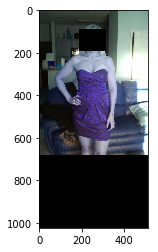

In [81]:
print(la[8])
plt.imshow(im[8])
plt.show()

In [25]:
import json
f = open('./dataset/women_sample_label.json','r')
info = json.load(f)
f.close()

In [29]:
for i in range(BATCH_SIZE):
    name = ge.names[i]
    print(name,info[name]['label'],la[i])

27000-27000-1.jpg 3 [0. 0. 0. 1.]
16000-16098-1.jpg 3 [0. 0. 0. 1.]
14000-14991-2.jpg 2 [0. 0. 1. 0.]
10000-10027-4.jpg 2 [0. 0. 1. 0.]
22000-22745-9.jpg 3 [0. 0. 0. 1.]
24000-24761-1.jpg 1 [0. 1. 0. 0.]
30000-30681-1.jpg 2 [0. 0. 1. 0.]
39000-39904-1.jpg 2 [0. 0. 1. 0.]
25000-25947-1.jpg 0 [1. 0. 0. 0.]
21000-21955-4.jpg 3 [0. 0. 0. 1.]
30000-30010-3.jpg 3 [0. 0. 0. 1.]
13000-13654-5.jpg 3 [0. 0. 0. 1.]
18000-18905-1.jpg 1 [0. 1. 0. 0.]
25000-25999-1.jpg 1 [0. 1. 0. 0.]
12000-12346-2.jpg 3 [0. 0. 0. 1.]
18000-18429-1.jpg 1 [0. 1. 0. 0.]
11000-11668-1.jpg 1 [0. 1. 0. 0.]
10000-10629-7.jpg 3 [0. 0. 0. 1.]
38000-38386-1.jpg 3 [0. 0. 0. 1.]
37000-37565-1.jpg 2 [0. 0. 1. 0.]
17000-17368-3.jpg 2 [0. 0. 1. 0.]
10000-10392-7.jpg 2 [0. 0. 1. 0.]
40000-40567-2.jpg 1 [0. 1. 0. 0.]
18000-18984-2.jpg 3 [0. 0. 0. 1.]
17000-17453-2.jpg 1 [0. 1. 0. 0.]
23000-23742-6.jpg 3 [0. 0. 0. 1.]
8000-8917-3.jpg 1 [0. 1. 0. 0.]
30000-30196-2.jpg 1 [0. 1. 0. 0.]
27000-27333-4.jpg 1 [0. 1. 0. 0.]
35000-35649-1.jp

In [12]:
model = build_model()

In [13]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1024, 512, 3)  0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 512, 256, 64)  9472        input_1[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 512, 256, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 512, 256, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

# train

In [16]:
layer_dict = {
            # all layers but the backbone
            "heads": r"(fc.*)",
            # From a specific Resnet stage and up
            "3+": r"(res3.*)|(bn3.*)|(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(fc.*)",
            "4+": r"(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(fc.*)",
            "5+": r"(res5.*)|(bn5.*)|(fc.*)",
            # All layers
            "all": ".*",
        }

In [17]:
model = build_model()
train_layer = layer_dict['heads']
set_trainable(train_layer,model)
if opt_string == "momentum":
    opt = tf.keras.optimizers.SGD(lr=LEARNING_RATE,momentum=MOMENTUM)
if opt_string == "nesterov":
    opt = tf.keras.optimizers.SGD(lr=LEARNING_RATE,momentum=MOMENTUM,nesterov=True)
if opt_string == "adam":
    opt = tf.keras.optimizers.Adam(lr=LEARNING_RATE,beta_1=ADAM_BETA_1,beta_2=ADAM_BETA_2)
# model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['categorical_accuracy'])
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=[ca])
#model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

# train_generator = generator(im_dir,train_json,BATCH_SIZE)
# train_generator = mysequence(im_dir, train_json, BATCH_SIZE)
train_generator = mysequence(im_dir, sample_json, BATCH_SIZE)
# |train_generator = generator(im_dir, sample_json, BATCH_SIZE)
# val_generator = generator(im_dir,val_json,BATCH_SIZE)
# val_generator = mysequence(im_dir, val_json, BATCH_SIZE)
val_generator = mysequence(im_dir, sample_json, BATCH_SIZE)
# val_generator = generator(im_dir, sample_json, BATCH_SIZE)


In: res50_softmax
The trainable layers:
  fc_softmax


InvalidArgumentError: You must feed a value for placeholder tensor 'fc_softmax_target' with dtype float and shape [?,?]
	 [[Node: fc_softmax_target = Placeholder[dtype=DT_FLOAT, shape=[?,?], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'fc_softmax_target', defined at:
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/asyncio/base_events.py", line 1425, in _run_once
    handle._run()
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-57b1002d21aa>", line 11, in <module>
    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=[ca])
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/site-packages/tensorflow/python/keras/_impl/keras/engine/training.py", line 744, in compile
    dtype=K.dtype(self.outputs[i]))
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/site-packages/tensorflow/python/keras/_impl/keras/backend.py", line 664, in placeholder
    x = array_ops.placeholder(dtype, shape=shape, name=name)
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1599, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3091, in _placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'fc_softmax_target' with dtype float and shape [?,?]
	 [[Node: fc_softmax_target = Placeholder[dtype=DT_FLOAT, shape=[?,?], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


In [ ]:
now = datetime.datetime.now()

base_name = 'res50_softmax_' + opt_string
log_dir = os.path.join(base_dir, base_name+"_{:%Y%m%dT%H%M}".format(now))
checkpoint_path = os.path.join(log_dir, base_name+"_*epoch*.h5")
checkpoint_path = checkpoint_path.replace("*epoch*", "{epoch:04d}")

In [ ]:
if IS_SAVE:
    callbacks = [
            LRTensorBoard(log_dir=log_dir,
                    histogram_freq=0, write_graph=True, write_images=False),
            # tf.keras.callbacks.TensorBoard(log_dir=log_dir,
            #          histogram_freq=0, write_graph=True, write_images=False),
            tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                    verbose=0, save_weights_only=True),
            tf.keras.callbacks.LearningRateScheduler(lrdecay),
        ]
else:
    callbacks = [
            #tf.keras.callbacks.LambdaCallback(on_batch_end=batchEnd,on_epoch_end=batchEnd),
            tf.keras.callbacks.LearningRateScheduler(lrdecay),
        ]

In [ ]:
model.fit_generator(train_generator,
                   steps_per_epoch = 1,
                   epochs = 20,
                   validation_data=val_generator,
                   validation_steps=1,
                   callbacks=callbacks,
                   workers = multiprocessing.cpu_count(),
                   max_queue_size = 10,
                   shuffle = True,
                   use_multiprocessing = True)

Epoch 1/20
1/1 [==============================] - 37s - loss: 1.3477 - ca: 0.4250 - val_loss: 1.9705 - val_ca: 0.4500
Epoch 2/20
1/1 [==============================] - 28s - loss: 1.3208 - ca: 0.4250 - val_loss: 1.9654 - val_ca: 0.4500
Epoch 3/20
1/1 [==============================] - 21s - loss: 1.2774 - ca: 0.4250 - val_loss: 1.9571 - val_ca: 0.4500
Epoch 4/20
1/1 [==============================] - 24s - loss: 1.2297 - ca: 0.4750 - val_loss: 1.9516 - val_ca: 0.4500
Epoch 5/20
1/1 [==============================] - 24s - loss: 1.1870 - ca: 0.4250 - val_loss: 1.9529 - val_ca: 0.4500
Epoch 6/20


# Inference

In [28]:
import matplotlib.pyplot as plt

In [39]:
model_path = './logs/res50_softmax_momentum_20180710T1501/res50_softmax_momentum_0001.h5'

In [40]:
model = build_model()
model.load_weights(model_path)

[[0.02109001 0.16364387 0.19086121 0.62440485]]
{'bmi': '29.15', 'label': 3}
[3]
[[0. 0. 0. 1.]]


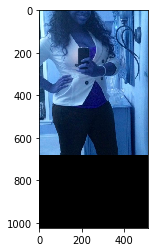

In [41]:
im_dir = './dataset/image_women/'

f = open('./dataset/women_sample_label.json','r')
info = json.load(f)
f.close()

names = list(info.keys())
name = names[1]

path = os.path.join(im_dir,name)
im = imread(path)
im = np.array([im])
result = model.predict(im)
print(result)
result_ = np.argmax(result,axis=-1)

print(info[name])
print(result_)

labels = np.array([info[name]['label']])

la = tf.keras.utils.to_categorical(labels,num_classes = 4)
print(la)

plt.imshow(im[0])
plt.show()

In [35]:
right = 0
error = 0
f = open('./dataset/women_sample_label.json','r')
info = json.load(f)
f.close()

names = list(info.keys())
for name in names:
    path = os.path.join(im_dir,name)
    im = imread(path)
    im = np.array([im])
    result = model.predict(im)
    result = np.argmax(result)
    
    if info[name]['label'] == result:
        right += 1
    else:
        error += 1

In [36]:
print(right/(right+error))

0.45
